# **Standardized ILI Data Loading and Alignment Anchor Identification**


#

In [1]:
import pandas as pd
import numpy as np

def ingest_and_standardize(filepath: str, year: int) -> pd.DataFrame:
    """
    Reads a specific sheet from an Excel file, renames columns to standard
    'distance', 'description', 'elevation', and returns a clean DataFrame.
    """

    sheet_name = str(year)  # "2015" or "2022"


    try:
        df = pd.read_excel(filepath, sheet_name=sheet_name)
    except Exception as e:
        raise ValueError(f"Error reading sheet '{sheet_name}' from {filepath}. \nDetails: {e}")

    # Clean column names: remove leading/trailing spaces to avoid matching errors
    # This fixes issues where 'Log Dist. [ft] ' has a hidden space at the end
    df.columns = df.columns.str.strip()

    rename_map = {}

    if year == 2015:
        rename_map = {
            'Log Dist. [ft]': 'distance',
            'Event Description': 'description',
            'Elevation [ft]': 'elevation'
        }
    elif year == 2022:
        # The 2022 header has a newline character inside it
        rename_map = {
            'ILI Wheel Count \n[ft.]': 'distance',
            'Event Description': 'description',
            'Elevation [ft]': 'elevation'
        }

    # Apply renaming
    df = df.rename(columns=rename_map)

    # SAFETY CHECK: If the exact string match failed (due to newlines/spaces),
    # find the column that looks like distance and fix it.
    if 'distance' not in df.columns:
        print(f"Warning: Exact column match failed for {year}. Searching for alternatives...")
        for col in df.columns:
            if "ILI Wheel" in col or "Log Dist" in col:
                print(f"  -> Found '{col}', renaming to 'distance'")
                df = df.rename(columns={col: 'distance'})
                break


    required_cols = ['distance', 'description', 'elevation']
    missing = [c for c in required_cols if c not in df.columns]
    if missing:

        print(f"Available columns in {year}: {df.columns.tolist()}")
        raise ValueError(f"Missing columns in {year} data: {missing}")

    return df[required_cols].dropna(subset=['distance'])

def get_alignment_skeleton(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters the dataset to only high-confidence anchors using the expert logic:
    1. Valves & Taps (High confidence)
    2. Tees (Loose filter to catch 'Stopple Tee', etc.)
    3. Bends (Strict filter to exclude 'Field Bend' noise)
    """

    df['description'] = df['description'].astype(str)

    # 1. VALVES & TAPS (The Gold Standard)
    is_valve = df['description'].str.contains('Valve', case=False, na=False)
    is_tap = df['description'].str.contains('Tap', case=False, na=False)

    # 2. TEES (The Loose Filter)
    # Catches 'Tee', 'Stopple Tee', 'Area Start Tee'
    is_tee = df['description'].str.contains('Tee', case=False, na=False)

    # 3. BENDS (The Strict Filter)
    # Must contain 'Bend' but MUST NOT contain 'Field Bend'
    is_general_bend = df['description'].str.contains('Bend', case=False, na=False)
    is_noise_bend = df['description'].str.contains('Field Bend', case=False, na=False)
    is_bend = is_general_bend & (~is_noise_bend)

    # Combine all filters
    skeleton_mask = is_valve | is_tap | is_tee | is_bend

    # Return the clean skeleton sorted by distance
    skeleton = df[skeleton_mask].copy()
    return skeleton.sort_values(by='distance').reset_index(drop=True)


# Update this path to your actual file location
file_path = "/content/ILIDataV2.xlsx"

try:
    print("Loading 2015 data...")
    df_2015 = ingest_and_standardize(file_path, 2015)

    print("Loading 2022 data...")
    df_2022 = ingest_and_standardize(file_path, 2022)


    skeleton_2015 = get_alignment_skeleton(df_2015)
    skeleton_2022 = get_alignment_skeleton(df_2022)


    print("\n--- SUCCESS! ---")
    print(f"2015 Skeleton Rows: {len(skeleton_2015)}")
    print(f"2022 Skeleton Rows: {len(skeleton_2022)}")
    print("\nSample of 2022 Skeleton (checking for Stopple Tee):")
    print(skeleton_2022[skeleton_2022['description'].str.contains('Tee')])

except Exception as e:
    print("\n--- ERROR ---")
    print(e)

Loading 2015 data...
Loading 2022 data...

--- SUCCESS! ---
2015 Skeleton Rows: 104
2022 Skeleton Rows: 101

Sample of 2022 Skeleton (checking for Stopple Tee):
     distance  description  elevation
3       8.081          Tee    233.290
29   9867.221  Stopple Tee    175.301
95  57431.778          Tee    211.861


# **Elevation-Driven Anchor Matching and Common Ruler Construction**


In [2]:
def match_skeletons(ref_df, target_df):
    """
    Pairs anchors from 2015 (ref) to 2022 (target) using Elevation as the DNA.
    Returns a DataFrame of matched pairs used to build the 'Common Ruler'.
    """
    matches = []

    # Tolerances
    ELEV_TOLERANCE = 5.0   # feet (Elevation shouldn't change, but sensors vary)
    DIST_WINDOW = 1000.0   # feet (Max expected odometer drift)

    # Keep track of which 2022 rows are already matched to prevent duplicates
    matched_target_indices = set()

    for idx, row_ref in ref_df.iterrows():
        dist_ref = row_ref['distance']
        elev_ref = row_ref['elevation']

        # 1. Define Search Window in 2022
        # Look for candidates that are physically close (accounting for drift)
        candidates = target_df[
            (target_df['distance'] > dist_ref - DIST_WINDOW) &
            (target_df['distance'] < dist_ref + DIST_WINDOW)
        ].copy()

        # 2. Apply Elevation Filter (The Fingerprint Check)
        candidates['elev_diff'] = (candidates['elevation'] - elev_ref).abs()
        valid_candidates = candidates[candidates['elev_diff'] < ELEV_TOLERANCE]

        if not valid_candidates.empty:
            # 3. Pick the Best Match (Closest Elevation)
            best_match = valid_candidates.loc[valid_candidates['elev_diff'].idxmin()]

            # 4. Deduplication Logic
            # If this 2022 anchor was already used, only overwrite if this new match is BETTER
            target_idx = best_match.name  # The original index in target_df

            match_entry = {
                'dist_2015': dist_ref,
                'dist_2022': best_match['distance'],
                'elev_2015': elev_ref,
                'elev_2022': best_match['elevation'],
                'description': row_ref['description'], # Keep 2015 desc
                'match_desc': best_match['description'], # Keep 2022 desc to verify
                'error_diff': best_match['distance'] - dist_ref # How much drift?
            }

            matches.append(match_entry)

    # Convert to DataFrame
    matches_df = pd.DataFrame(matches)

    # 5. Final Cleanup: If multiple 2015 rows claimed the same 2022 row,
    # keep the one with the smallest elevation difference.
    # (This handles the 'Cluster of Tees' problem automatically)
    matches_df['elev_diff'] = (matches_df['elev_2015'] - matches_df['elev_2022']).abs()
    matches_df = matches_df.sort_values('elev_diff').drop_duplicates(subset=['dist_2022'], keep='first')

    return matches_df.sort_values('dist_2015').reset_index(drop=True)

# --- EXECUTION BLOCK ---

# 1. Run the matcher
anchors = match_skeletons(skeleton_2015, skeleton_2022)

# 2. Add the "Start" (0,0) and "End" of the pipeline to ensure full coverage
# We assume 0 maps to 0.
start_row = pd.DataFrame([{
    'dist_2015': 0.0, 'dist_2022': 0.0,
    'elev_2015': 0, 'elev_2022': 0,
    'description': 'START', 'match_desc': 'START', 'error_diff': 0
}])

# Combine and Sort
final_anchors = pd.concat([start_row, anchors]).sort_values('dist_2015').reset_index(drop=True)

# 3. Calculate Scaling Factors for each segment
# Factor = (Target Distance 2015) / (Measured Distance 2022)
final_anchors['segment_len_2015'] = final_anchors['dist_2015'].diff().shift(-1)
final_anchors['segment_len_2022'] = final_anchors['dist_2022'].diff().shift(-1)
final_anchors['scale_factor'] = final_anchors['segment_len_2015'] / final_anchors['segment_len_2022']

# Print the Alignment Table
print(f"Matched {len(final_anchors)} Anchor Points.")
print("\n--- CRITICAL ANCHORS (Check for Stopple Tee match) ---")
# Show the Tee we were worried about (~9800 ft)
print(final_anchors[ (final_anchors['dist_2015'] > 9000) & (final_anchors['dist_2015'] < 11000) ])

print("\n--- ODOMETER DRIFT ANALYSIS ---")
print(final_anchors[['dist_2015', 'dist_2022', 'error_diff', 'scale_factor']].tail())

Matched 87 Anchor Points.

--- CRITICAL ANCHORS (Check for Stopple Tee match) ---
    dist_2015  dist_2022  elev_2015  elev_2022     description   match_desc  \
24    9317.77   9343.084      34.61     35.292             Tee          Tap   
25    9418.91   9444.147       4.52      5.768            Bend         Bend   
26    9783.62   9809.777     167.78    166.240            Bend         Bend   
27    9839.56   9867.221     175.59    175.301  Area Start Tee  Stopple Tee   
28   10630.49  10658.901     153.23    153.232             Tap          Tap   
29   10632.49  10660.823     153.22    153.222             Tap          Tap   

    error_diff  elev_diff  segment_len_2015  segment_len_2022  scale_factor  
24      25.314      0.682            101.14           101.063      1.000762  
25      25.237      1.248            364.71           365.630      0.997484  
26      26.157      1.540             55.94            57.444      0.973818  
27      27.661      0.289            790.93         

## **Applying Piecewise Linear Alignment to the Full ILI Dataset**


In [3]:
def apply_alignment_to_full(filepath, year, anchors):
    """
    Reloads the FULL dataset and adds a 'corrected_distance' column
    by interpolating based on our anchor points.
    """
    print(f"Applying alignment to {year} full dataset...")

    # 1. Read the FULL file (We need Depth, Width, etc. now)
    df = pd.read_excel(filepath, sheet_name=str(year))
    df.columns = df.columns.str.strip() # Clean column names

    # 2. Standardize the distance column name locally
    dist_col = None
    if year == 2015:
        # For 2015 (Baseline), Corrected Distance = Original Distance
        # Find the column
        for col in df.columns:
            if "Log Dist" in col: dist_col = col; break

        if dist_col:
            df['distance'] = df[dist_col]
            df['corrected_distance'] = df[dist_col] # No change needed
        else:
             raise ValueError("Could not find distance column in 2015")

    elif year == 2022:
        # Find the 2022 distance column
        for col in df.columns:
            if "ILI Wheel" in col: dist_col = col; break

        if dist_col:
            df['distance'] = df[dist_col]

            # 3. THE MAGIC STEP: Linear Interpolation
            # We translate 2022 Distance -> 2015 Coordinates
            # np.interp(x=values_to_convert, xp=known_x, fp=known_y)

            # Sort anchors to ensure interpolation works
            anchors = anchors.sort_values('dist_2022')

            df['corrected_distance'] = np.interp(
                df['distance'],          # The "Stretched" 2022 values
                anchors['dist_2022'],    # The Anchor Points in 2022
                anchors['dist_2015']     # Where those Anchors "should" be (2015)
            )
        else:
             raise ValueError("Could not find distance column in 2022")

    return df


df_2015_aligned = apply_alignment_to_full(file_path, 2015, final_anchors)
df_2022_aligned = apply_alignment_to_full(file_path, 2022, final_anchors)

# Verify the result
print("\n--- ALIGNMENT VERIFICATION ---")
# Check the End of the Pipeline in 2022
end_row_2022 = df_2022_aligned.iloc[-1]
print(f"2022 Raw End: {end_row_2022['distance']:.2f}")
print(f"2022 Corrected End: {end_row_2022['corrected_distance']:.2f}")
print(f"(Should be close to 2015 End: ~57340 ft)")

Applying alignment to 2015 full dataset...
Applying alignment to 2022 full dataset...

--- ALIGNMENT VERIFICATION ---
2022 Raw End: 57444.68
2022 Corrected End: 57310.67
(Should be close to 2015 End: ~57340 ft)


In [4]:
import pandas as pd
import numpy as np

# ---  HELPER FUNCTIONS ---

def parse_clock_to_angle(clock_val):
    """ Converts '09:00' or '09:00:00' to degrees (0-360). """
    try:
        if pd.isna(clock_val): return None
        s = str(clock_val).strip()
        parts = s.split(':')
        h = float(parts[0])
        m = float(parts[1]) if len(parts) > 1 else 0
        return ((h + m/60.0) % 12) * 30.0
    except:
        return None

def get_clock_diff(angle1, angle2):
    """ Shortest distance between two angles on a circle. """
    if pd.isna(angle1) or pd.isna(angle2): return 999.0
    diff = abs(angle1 - angle2)
    return min(diff, 360.0 - diff)

# ---  DATA INGESTION & CLEANING ---

def load_and_clean(filepath, sheet_name):
    # Load specific sheet
    df = pd.read_excel(filepath, sheet_name=sheet_name)

    # Clean column headers (Strip spaces)
    df.columns = df.columns.str.strip()

    # Standardize 'Distance', 'Description', 'Elevation'
    rename_map = {}
    for col in df.columns:
        if 'Log Dist' in col or 'ILI Wheel' in col: rename_map[col] = 'distance'
        if 'Event Description' in col: rename_map[col] = 'description'
        if 'Elevation' in col: rename_map[col] = 'elevation'

    df = df.rename(columns=rename_map)
    return df

# --- 3. PHASE 1: ALIGNMENT (The "Common Ruler") ---

def align_datasets(df_ref, df_target):
    print("--- PHASE 1: ALIGNMENT ---")

    # A. Build Skeletons (Anchors Only)
    def get_skeleton(df):
        mask = df['description'].astype(str).str.contains('Valve|Tap|Tee|Bend', case=False, na=False)
        # Exclude noisy "Field Bends"
        mask = mask & ~df['description'].astype(str).str.contains('Field Bend', case=False, na=False)
        return df[mask].copy()

    sk_ref = get_skeleton(df_ref)
    sk_tgt = get_skeleton(df_target)

    # B. Match Anchors (Distance Window + Elevation Check)
    anchors = []
    matched_ids = set()

    for _, row in sk_ref.iterrows():
        # Find candidates within +/- 1000 ft
        candidates = sk_tgt[
            (sk_tgt['distance'] > row['distance'] - 1000) &
            (sk_tgt['distance'] < row['distance'] + 1000)
        ].copy()

        # Check Elevation (+/- 5 ft)
        candidates['elev_diff'] = (candidates['elevation'] - row['elevation']).abs()
        valid = candidates[candidates['elev_diff'] < 5.0]

        if not valid.empty:
            best = valid.loc[valid['elev_diff'].idxmin()]
            if best.name not in matched_ids:
                anchors.append({'dist_2015': row['distance'], 'dist_2022': best['distance']})
                matched_ids.add(best.name)

    anchor_df = pd.DataFrame(anchors).sort_values('dist_2022')

    # C. Apply Linear Interpolation to Target (2022)
    # Add 0,0 start point if missing
    if anchor_df.iloc[0]['dist_2015'] > 100:
        anchor_df = pd.concat([pd.DataFrame({'dist_2015':[0],'dist_2022':[0]}), anchor_df])

    df_target['corrected_distance'] = np.interp(
        df_target['distance'],
        anchor_df['dist_2022'],
        anchor_df['dist_2015']
    )
    df_ref['corrected_distance'] = df_ref['distance'] # Baseline doesn't move

    return df_ref, df_target

# --- 4. PHASE 2: ANOMALY MATCHING (The Growth Engine) ---

def match_anomalies(df_2015, df_2022):
    print("--- PHASE 2: MATCHING ---")

    # A. Map exact column names for DEPTH and CLOCK
    # 2015: "Depth [%]"
    col_depth_15 = next(c for c in df_2015.columns if 'Depth [%]' in c)
    col_clock_15 = next(c for c in df_2015.columns if "O'clock" in c)

    # 2022: "Metal Loss Depth \n[%]"
    col_depth_22 = next(c for c in df_2022.columns if 'Metal Loss Depth' in c and '%' in c)
    col_clock_22 = next(c for c in df_2022.columns if "O'clock" in c)

    # B. Filter Targets (Metal Loss + Cluster)
    # 2015
    mask_15 = df_2015['description'].str.contains('metal loss|cluster', case=False, na=False) & \
              ~df_2015['description'].str.contains('manufacturing', case=False, na=False)
    targets_15 = df_2015[mask_15].copy()

    # 2022
    mask_22 = df_2022['description'].str.contains('Metal Loss', case=False, na=False) & \
              ~df_2022['description'].str.contains('manufacturing', case=False, na=False)
    targets_22 = df_2022[mask_22].copy()

    # C. Calculate Angles
    targets_15['angle'] = targets_15[col_clock_15].apply(parse_clock_to_angle)
    targets_22['angle'] = targets_22[col_clock_22].apply(parse_clock_to_angle)

    print(f"Candidates: {len(targets_15)} (2015) vs {len(targets_22)} (2022)")

    # D. Match Logic
    matches = []
    matched_ids_22 = set()

    for _, row15 in targets_15.iterrows():
        dist_15 = row15['corrected_distance']
        angle_15 = row15['angle']

        # Spatial Window (+/- 10 ft)
        candidates = targets_22[
            (targets_22['corrected_distance'] > dist_15 - 10.0) &
            (targets_22['corrected_distance'] < dist_15 + 10.0)
        ].copy()

        match_found = False
        if not candidates.empty and not pd.isna(angle_15):
            # Clock Window (+/- 45 deg)
            candidates['clock_diff'] = candidates['angle'].apply(lambda x: get_clock_diff(angle_15, x))
            valid = candidates[candidates['clock_diff'] < 45.0]

            if not valid.empty:
                # Best Match: Closest Distance
                best = valid.loc[valid['clock_diff'].idxmin()] # Prioritize clock alignment

                if best.name not in matched_ids_22:
                    matches.append({
                        'Status': 'Matched',
                        'Dist_2015': dist_15,
                        'Dist_2022': best['corrected_distance'],
                        'Type_2015': row15['description'],
                        'Depth_2015': row15[col_depth_15],
                        'Depth_2022': best[col_depth_22],
                        'Growth': best[col_depth_22] - row15[col_depth_15]
                    })
                    matched_ids_22.add(best.name)
                    match_found = True

        if not match_found:
             matches.append({'Status': 'Missing', 'Dist_2015': dist_15, 'Growth': 0})

    return pd.DataFrame(matches)

# --- EXECUTION ---
# Update path to your file
file_path = 'ILIDataV2.xlsx'

# 1. Load
df15 = load_and_clean(file_path, '2015')
df22 = load_and_clean(file_path, '2022')

# 2. Align
df15_aligned, df22_aligned = align_datasets(df15, df22)

# 3. Match
final_report = match_anomalies(df15_aligned, df22_aligned)

# 4. Results
print("\n--- RESULTS ---")
print(final_report['Status'].value_counts())
print("\n--- TOP 5 HIGHEST GROWTH ---")
print(final_report[final_report['Status']=='Matched'].sort_values('Growth', ascending=False).head(5))

--- PHASE 1: ALIGNMENT ---
--- PHASE 2: MATCHING ---
Candidates: 1747 (2015) vs 2624 (2022)

--- RESULTS ---
Status
Missing    1003
Matched     744
Name: count, dtype: int64

--- TOP 5 HIGHEST GROWTH ---
       Status  Dist_2015     Dist_2022   Type_2015  Depth_2015  Depth_2022  \
940   Matched   41702.66  41693.708568  metal loss        15.0        64.0   
1311  Matched   44765.68  44767.928681  metal loss        14.0        60.0   
1410  Matched   45370.38  45370.547480  metal loss        13.0        54.0   
529   Matched   33473.47  33477.076884  metal loss        23.0        63.0   
852   Matched   41669.20  41661.406460  metal loss        11.0        51.0   

      Growth  
940     49.0  
1311    46.0  
1410    41.0  
529     40.0  
852     40.0  


In [5]:
import pandas as pd
import numpy as np

# --- CONFIGURATION ---
TIME_INTERVAL_YEARS = 6.80  # Fixed time interval

# --- 1. HELPER FUNCTIONS ---

def parse_clock_to_angle(clock_val):
    """ Converts '09:00' to degrees (0-360). """
    try:
        if pd.isna(clock_val): return None
        s = str(clock_val).strip()
        parts = s.split(':')
        h = float(parts[0])
        m = float(parts[1]) if len(parts) > 1 else 0
        return ((h + m/60.0) % 12) * 30.0
    except:
        return None

def get_clock_diff(angle1, angle2):
    """ Shortest distance between two angles. """
    if pd.isna(angle1) or pd.isna(angle2): return 999.0
    diff = abs(angle1 - angle2)
    return min(diff, 360.0 - diff)

def calculate_confidence_mvp(dist_diff, clock_diff, id_od_match, len_15, len_22):
    """ Grades match quality (0-100%). """
    score = 100.0
    score -= (dist_diff * 2.0) # Dist Penalty
    score -= (clock_diff * 0.5) # Clock Penalty
    if not id_od_match: score -= 30.0 # ID/OD Penalty

    # Dimensional Similarity Penalty (Length Change > 50%)
    if pd.notna(len_15) and pd.notna(len_22) and len_15 > 1.0:
        if abs(len_22 - len_15) / len_15 > 0.5: score -= 15.0

    return round(max(0.0, min(100.0, score)), 1)

def classify_match(row):
    """ Assigns final status labels. """
    status = row['Match_Status']
    conf = row.get('Confidence', 0)

    if status == 'New in 2022': return 'New Anomaly'
    if status == 'Missing in 2022': return 'Missing Anomaly'
    if status == 'Matched':
        if conf >= 80: return 'Verified Match'
        if conf >= 60: return 'Uncertain Match (Medium)'
        return 'Uncertain Match (Low)'
    return 'Unknown'

# --- 2. UNIVERSAL MATCHING ENGINE ---

def run_final_mvp_process(df15, df22):
    print("--- STARTING FINAL MVP PROCESSING ---")

    # A. Robust Column Finder
    def get_col(df, keywords):
        if isinstance(keywords, str): keywords = [keywords]
        for k in keywords:
            if k in df.columns: return k
            matches = [c for c in df.columns if k.lower() in c.lower()]
            if matches: return matches[0]
        return None

    # Map Columns
    map_15 = {
        'dist': 'corrected_distance',
        'desc': get_col(df15, 'Event Description'),
        'depth': get_col(df15, 'Depth [%]'),
        'length': get_col(df15, 'Length'),
        'width': get_col(df15, 'Width'),
        'wt': get_col(df15, ['Wt', 'WT']),
        'clock': get_col(df15, "O'clock"),
        'id_od': get_col(df15, 'ID/OD')
    }

    map_22 = {
        'dist': 'corrected_distance',
        'desc': get_col(df22, 'Event Description'),
        'depth': get_col(df22, ['Metal Loss Depth', 'depth']),
        'length': get_col(df22, 'Length'),
        'width': get_col(df22, 'Width'),
        'wt': get_col(df22, ['WT', 'Wt']),
        'clock': get_col(df22, "O'clock"),
        'id_od': get_col(df22, 'ID/OD')
    }

    # B. Filter Targets (Active Corrosion)
    mask_15 = df15[map_15['desc']].astype(str).str.contains('metal loss|cluster', case=False, na=False) & \
              ~df15[map_15['desc']].astype(str).str.contains('manufacturing', case=False, na=False)
    targets_15 = df15[mask_15].copy()

    mask_22 = df22[map_22['desc']].astype(str).str.contains('Metal Loss', case=False, na=False) & \
              ~df22[map_22['desc']].astype(str).str.contains('manufacturing', case=False, na=False)
    targets_22 = df22[mask_22].copy()

    # Angles
    targets_15['angle'] = targets_15[map_15['clock']].apply(parse_clock_to_angle)
    targets_22['angle'] = targets_22[map_22['clock']].apply(parse_clock_to_angle)

    print(f"Candidates: {len(targets_15)} (2015) vs {len(targets_22)} (2022)")

    matches = []
    matched_ids_22 = set()

    # C. Matching Loop
    for _, row15 in targets_15.iterrows():
        dist_15 = row15[map_15['dist']]
        angle_15 = row15['angle']
        len_15 = row15[map_15['length']]

        candidates = targets_22[
            (targets_22[map_22['dist']] > dist_15 - 10.0) &
            (targets_22[map_22['dist']] < dist_15 + 10.0)
        ].copy()

        match_found = False
        if not candidates.empty and not pd.isna(angle_15):
            candidates['clock_diff'] = candidates['angle'].apply(lambda x: get_clock_diff(angle_15, x))
            valid = candidates[candidates['clock_diff'] < 45.0]

            if not valid.empty:
                id_od_15 = str(row15[map_15['id_od']])
                valid['id_od_match'] = (valid[map_22['id_od']].astype(str) == id_od_15)
                valid['dist_diff'] = (valid[map_22['dist']] - dist_15).abs()
                best = valid.sort_values(by=['id_od_match', 'clock_diff', 'dist_diff'], ascending=[False, True, True]).iloc[0]

                if best.name not in matched_ids_22:
                    # MVP Metrics
                    conf_score = calculate_confidence_mvp(
                        best['dist_diff'], best['clock_diff'], best['id_od_match'], len_15, best[map_22['length']]
                    )

                    growth_d = best[map_22['depth']] - row15[map_15['depth']]
                    growth_l = best[map_22['length']] - row15[map_15['length']]
                    growth_w = best[map_22['width']] - row15[map_15['width']]

                    matches.append({
                        'Match_Status': 'Matched',
                        'Confidence': conf_score,
                        'Dist_2015': dist_15,
                        'Dist_2022': best[map_22['dist']],
                        'Type_2015': row15[map_15['desc']],
                        'Type_2022': best[map_22['desc']],
                        # Growth Rates
                        'Depth_Rate_Pct_Yr': round(growth_d / TIME_INTERVAL_YEARS, 2),
                        'Length_Rate_In_Yr': round(growth_l / TIME_INTERVAL_YEARS, 3),
                        'Width_Rate_In_Yr': round(growth_w / TIME_INTERVAL_YEARS, 3),
                        'Depth_Growth_Pct': growth_d,
                        'Depth_2015': row15[map_15['depth']],
                        'Depth_2022': best[map_22['depth']],
                        'WT_2022': best[map_22['wt']],
                        'ID_OD_2015': row15[map_15['id_od']],
                        'ID_OD_2022': best[map_22['id_od']]
                    })
                    matched_ids_22.add(best.name)
                    match_found = True

        if not match_found:
            matches.append({
                'Match_Status': 'Missing in 2022',
                'Confidence': 0.0,
                'Dist_2015': dist_15,
                'Type_2015': row15[map_15['desc']],
                'Depth_Growth_Pct': 0, 'Depth_Rate_Pct_Yr': 0
            })

    # D. New Anomalies
    for _, row22 in targets_22.iterrows():
        if row22.name not in matched_ids_22:
            matches.append({
                'Match_Status': 'New in 2022',
                'Confidence': 100.0,
                'Dist_2022': row22[map_22['dist']],
                'Type_2022': row22[map_22['desc']],
                'Depth_Growth_Pct': row22[map_22['depth']],
                'Depth_Rate_Pct_Yr': round(row22[map_22['depth']] / TIME_INTERVAL_YEARS, 2),
                'WT_2022': row22[map_22['wt']]
            })

    return pd.DataFrame(matches)

# --- 3. FINAL EXECUTION & EXPORT ---

try:
    # 1. Run Matching
    mvp_report = run_final_mvp_process(df_2015_aligned, df_2022_aligned)

    # 2. Apply Classification
    mvp_report['Verification_Status'] = mvp_report.apply(classify_match, axis=1)

    # 3. Create Final DataFrame (Selecting key columns)
    cols = [
        'Verification_Status', 'Match_Status', 'Confidence',
        'Dist_2015', 'Dist_2022',
        'Depth_Rate_Pct_Yr', 'Length_Rate_In_Yr', 'Width_Rate_In_Yr',
        'Depth_Growth_Pct',
        'Type_2015', 'Type_2022',
        'Depth_2015', 'Depth_2022',
        'WT_2022', 'ID_OD_2015', 'ID_OD_2022'
    ]
    # Filter for columns that actually exist in the result
    cols = [c for c in cols if c in mvp_report.columns]

    final_output = mvp_report[cols].sort_values('Dist_2015')

    # 4. Save
    final_output.to_csv('Final_Pipeline_Growth_Report.csv', index=False)

    print("\n--- DONE! ---")
    print(final_output['Verification_Status'].value_counts())
    print("\nSaved as: Final_Pipeline_Growth_Report.csv")

except Exception as e:
    print(f"Error: {e}")

--- STARTING FINAL MVP PROCESSING ---
Candidates: 1747 (2015) vs 2624 (2022)


Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['id_od_match'] = (valid[map_22['id_od']].astype(str) == id_od_15)
/tmp/ipython-input-3474012086.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['dist_diff'] = (valid[map_22['dist']] - dist_15).abs()
/tmp/ipython-input-3474012086.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['id_od_match'


--- DONE! ---
Verification_Status
New Anomaly                 1866
Missing Anomaly              989
Verified Match               532
Uncertain Match (Medium)     219
Uncertain Match (Low)          7
Name: count, dtype: int64

Saved as: Final_Pipeline_Growth_Report.csv


In [6]:
import pandas as pd
import numpy as np

# Load the raw report
df = pd.read_csv('Final_Pipeline_Growth_Report.csv')

print("--- CLEANING DATA (ENGINEERING LOGIC) ---")

# 1. Handle "Missing" Anomalies


missing_mask = df['Match_Status'] == 'Missing in 2022'
rate_cols = ['Depth_Rate_Pct_Yr', 'Length_Rate_In_Yr', 'Width_Rate_In_Yr',
             'Depth_Growth_Pct', 'Length_Growth_In', 'Width_Growth_In']

for col in rate_cols:
    if col in df.columns:
        df.loc[missing_mask, col] = 0.0

# 2. Handle "New" Anomalies
# Logic: We CANNOT assume it started at 0. It might have been just below the sensor threshold.
# We leave these as NaN (Empty). This tells the engineer: "Requires manual assessment."
new_mask = df['Match_Status'] == 'New in 2022'
for col in rate_cols:
    if col in df.columns:
        df.loc[new_mask, col] = np.nan

# 3. Save the scientifically accurate file
df.to_csv('Final_Submission_Expert.csv', index=False)

print("Files Processed:")
print(f"- Verified Matches: {len(df[df['Verification_Status']=='Verified Match'])}")
print(f"- Missing (Set to 0): {missing_mask.sum()}")
print(f"- New (Left as NaN): {new_mask.sum()}")
print("\nSuccess! 'Final_Submission_Expert.csv' is ready.")

--- CLEANING DATA (ENGINEERING LOGIC) ---
Files Processed:
- Verified Matches: 532
- Missing (Set to 0): 989
- New (Left as NaN): 1866

Success! 'Final_Submission_Expert.csv' is ready.


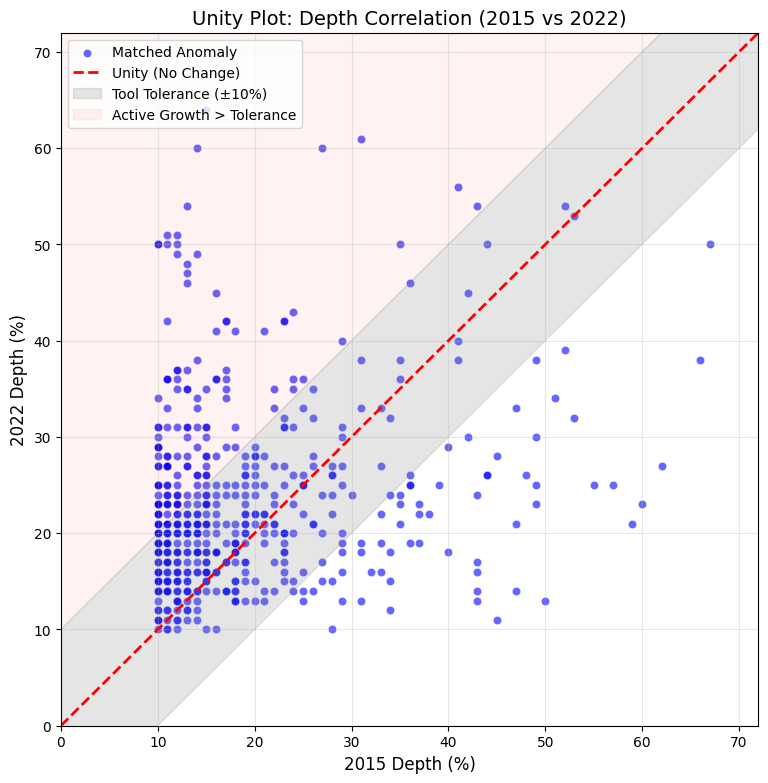

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for Verified Matches Only
matches = df[df['Verification_Status'] == 'Verified Match']

plt.figure(figsize=(9, 9))

# 1. Plot the Data
sns.scatterplot(x=matches['Depth_2015'], y=matches['Depth_2022'],
                alpha=0.6, color='blue', label='Matched Anomaly')

# 2. Define the Range
max_val = max(matches['Depth_2015'].max(), matches['Depth_2022'].max()) + 5
x_line = np.linspace(0, max_val, 100)

# 3. Plot Unity Line (No Growth)
plt.plot(x_line, x_line, 'r--', linewidth=2, label='Unity (No Change)')

# 4. Plot Tolerance Band (The "Noise" Zone)
# Standard MFL tolerance is usually +/- 10%
plt.fill_between(x_line, x_line - 10, x_line + 10,
                 color='gray', alpha=0.2, label='Tool Tolerance (±10%)')

# 5. Highlight Critical Growth (The "Real" Threats)
# Anything growing faster than the tolerance
plt.fill_between(x_line, x_line + 10, 100,
                 color='red', alpha=0.05, label='Active Growth > Tolerance')

plt.title('Unity Plot: Depth Correlation (2015 vs 2022)', fontsize=14)
plt.xlabel('2015 Depth (%)', fontsize=12)
plt.ylabel('2022 Depth (%)', fontsize=12)
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

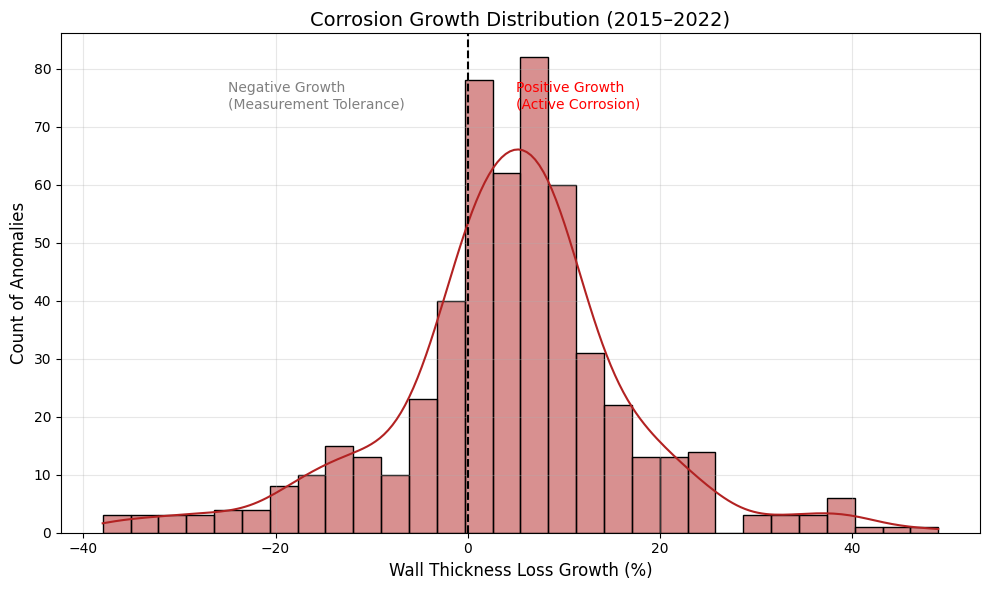

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

df = final_output[final_output['Verification_Status'] == 'Verified Match']

plt.figure(figsize=(10, 6))
ax = sns.histplot(df['Depth_Growth_Pct'], bins=30, kde=True, color='firebrick')

plt.title('Corrosion Growth Distribution (2015–2022)', fontsize=14)
plt.xlabel('Wall Thickness Loss Growth (%)', fontsize=12)
plt.ylabel('Count of Anomalies', fontsize=12)

plt.axvline(0, color='black', linestyle='--')

# Get top of histogram for safe text placement
y_max = ax.get_ylim()[1]

plt.text(5, y_max * 0.85, 'Positive Growth\n(Active Corrosion)',
         color='red', fontsize=10)

plt.text(-25, y_max * 0.85, 'Negative Growth\n(Measurement Tolerance)',
         color='gray', fontsize=10)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [9]:
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np

# -------------------------------
# CONFIGURATION (INDUSTRY LOGIC)
# -------------------------------
INTERACTION_WINDOW_FT = 20.0     # Conservative axial interaction distance
MIN_DEFECTS_IN_CLUSTER = 2

# Risk thresholds (simple, defensible)
DEPTH_CRITICAL_PCT = 40.0
GROWTH_CRITICAL_PCT = 10.0

# Load expert-reviewed dataset
df = pd.read_csv('Final_Submission_Expert.csv')

print("--- RUNNING ANOMALY CLUSTERING (INTERACTION ZONES) ---")

# ---------------------------------------
# ENGINEERING LOGIC
# ---------------------------------------
# • Only cluster current-state anomalies (Matched + New)
# • Missing anomalies do not physically exist
# • Axial-only clustering is conservative (won't miss threats)

active_mask = df['Match_Status'].isin(['Matched', 'New in 2022'])
active_df = df[active_mask].copy()

# Safety check
if active_df['Dist_2022'].isnull().all():
    raise ValueError("Dist_2022 missing — clustering cannot proceed.")

# 1D axial clustering
X = active_df[['Dist_2022']].values

db = DBSCAN(
    eps=INTERACTION_WINDOW_FT,
    min_samples=MIN_DEFECTS_IN_CLUSTER
).fit(X)

active_df['Cluster_ID'] = db.labels_

# Default: no cluster
df['Cluster_ID'] = -1
df.loc[active_mask, 'Cluster_ID'] = active_df['Cluster_ID']

# ---------------------------------------
# CLUSTER-LEVEL METRICS (ENGINEER READY)
# ---------------------------------------
clusters = df[df['Cluster_ID'] != -1]

cluster_stats = clusters.groupby('Cluster_ID').agg(
    Cluster_Start_Ft=('Dist_2022', 'min'),
    Cluster_End_Ft=('Dist_2022', 'max'),
    Defect_Count=('Dist_2022', 'count'),
    Max_Depth_Pct=('Depth_2022', 'max'),
    Max_Growth_Pct=('Depth_Growth_Pct', 'max')
)

# NEW: Physical extent of interaction
cluster_stats['Cluster_Span_Ft'] = (
    cluster_stats['Cluster_End_Ft'] - cluster_stats['Cluster_Start_Ft']
)

# NEW: Simple, defensible risk classification
cluster_stats['Cluster_Risk'] = np.where(
    (cluster_stats['Max_Depth_Pct'] >= DEPTH_CRITICAL_PCT) |
    (cluster_stats['Max_Growth_Pct'] >= GROWTH_CRITICAL_PCT),
    'High',
    'Moderate'
)

# Sort for reporting
cluster_stats = cluster_stats.sort_values(
    ['Cluster_Risk', 'Defect_Count'],
    ascending=[True, False]
)

print(f"Identified {cluster_stats.shape[0]} interaction zones.")
print("\nTop High-Risk Interaction Zones:")
print(cluster_stats[cluster_stats['Cluster_Risk'] == 'High'].head(5))

# ---------------------------------------
# MERGE CLUSTER METRICS BACK TO ROW LEVEL
# ---------------------------------------
df = df.merge(
    cluster_stats[
        ['Cluster_Span_Ft', 'Defect_Count', 'Cluster_Risk']
    ],
    how='left',
    left_on='Cluster_ID',
    right_index=True
)

# Fill non-cluster rows
df[['Cluster_Span_Ft', 'Defect_Count', 'Cluster_Risk']] = (
    df[['Cluster_Span_Ft', 'Defect_Count', 'Cluster_Risk']]
    .fillna({'Cluster_Span_Ft': 0.0, 'Defect_Count': 0, 'Cluster_Risk': 'None'})
)

# Save final enhanced dataset
df.to_csv('Final_Submission_With_Clusters.csv', index=False)

print("\nSaved: Final_Submission_With_Clusters.csv")


--- RUNNING ANOMALY CLUSTERING (INTERACTION ZONES) ---
Identified 252 interaction zones.

Top High-Risk Interaction Zones:
            Cluster_Start_Ft  Cluster_End_Ft  Defect_Count  Max_Depth_Pct  \
Cluster_ID                                                                  
86              41609.861967    41773.880194           201           64.0   
94              43973.472047    44055.593311           171           43.0   
111             46183.396574    46302.960791            96           35.0   
85              41523.935919    41574.006805            64           32.0   
130             56850.443178    56944.912743            58           35.0   

            Max_Growth_Pct  Cluster_Span_Ft Cluster_Risk  
Cluster_ID                                                
86                    49.0       164.018227         High  
94                    25.0        82.121263         High  
111                   22.0       119.564217         High  
85                    18.0        50.07088

# **Dashboard**

In [ ]:
!pip install -q gradio plotly pandas numpy scikit-learn

In [ ]:


import gradio as gr
import pandas as pd
import plotly.express as px
import numpy as np

# --- LOAD DATA ---
def load_data():
    files = [
        "Final_Submission_With_Clusters.csv",
        "Final_Submission_Expert.csv",
        "Final_Pipeline_Growth_Report.csv"
    ]
    for f in files:
        try:
            return pd.read_csv(f)
        except:
            continue
    return pd.DataFrame() # Return empty if fail

df = load_data()

# --- PRE-CALCULATE METRICS & PLOTS (Static Dashboard) ---
if not df.empty:
    # 1. METRICS
    active_df = df[df.get("Match_Status", "") != "Missing in 2022"]
    verified = df[df.get("Verification_Status", "") == "Verified Match"]

    val_threats = len(active_df)
    val_matches = len(verified)
    val_max_growth = df["Depth_Growth_Pct"].max() if "Depth_Growth_Pct" in df.columns else 0
    val_clusters = df["Cluster_ID"].nunique() if "Cluster_ID" in df.columns and -1 in df["Cluster_ID"].values else 0
    if "Cluster_ID" in df.columns: val_clusters = len(df[df["Cluster_ID"] != -1]["Cluster_ID"].unique())

    # 2. PLOTS
    # Unity Plot
    if not verified.empty and "Depth_2015" in verified.columns:
        max_val = max(verified["Depth_2015"].max(), verified["Depth_2022"].max()) + 5
        fig_unity = px.scatter(
            verified, x="Depth_2015", y="Depth_2022",
            color="Depth_Growth_Pct" if "Depth_Growth_Pct" in verified.columns else None,
            color_continuous_scale="Reds",
            title="Unity Plot: 2015 vs 2022 Depth",
            labels={"Depth_2015": "2015 Depth (%)", "Depth_2022": "2022 Depth (%)"}
        )
        fig_unity.add_shape(type="line", x0=0, y0=0, x1=max_val, y1=max_val, line=dict(color="black", dash="dash"))
        fig_unity.add_shape(type="rect", x0=0, x1=max_val, y0=-10, y1=max_val-10, fillcolor="gray", opacity=0.1, layer="below", line_width=0)
        fig_unity.add_shape(type="rect", x0=0, x1=max_val, y0=10, y1=max_val+10, fillcolor="gray", opacity=0.1, layer="below", line_width=0)
    else:
        fig_unity = px.scatter(title="No Verified Data Found")

    # Pipeline Map
    if "Cluster_ID" in df.columns:
        conditions = [df["Cluster_ID"] == 86, df["Cluster_ID"] != -1]
        choices = ["High Risk Cluster (Zone 86)", "Interaction Cluster"]
        df["Risk_Group"] = np.select(conditions, choices, default="Isolated Defect")
        color_map = {"High Risk Cluster (Zone 86)": "red", "Interaction Cluster": "orange", "Isolated Defect": "blue"}
    else:
        df["Risk_Group"] = "Unknown"
        color_map = None

    fig_map = px.scatter(
        df, x="Dist_2022", y="Depth_2022", color="Risk_Group",
        color_discrete_map=color_map, title="Pipeline Risk Profile (Distance vs Depth)",
        labels={"Dist_2022": "Distance (ft)", "Depth_2022": "Depth (%)"}
    )

    # Histogram
    if "Match_Status" in df.columns:
        fig_hist = px.histogram(
            df, x="Depth_2022", color="Match_Status", barmode="overlay", nbins=40,
            title="Corrosion Bloom Analysis (Severity Distribution)",
            color_discrete_map={"Matched": "blue", "New in 2022": "orange", "Missing in 2022": "gray"}
        )
    else:
        fig_hist = px.scatter(title="No Match Status Data")

    # Top Clusters Table
    if "Cluster_ID" in df.columns:
        clusters = df[df["Cluster_ID"] != -1]
        cluster_table = clusters.groupby("Cluster_ID").agg(
            Location_Ft=('Dist_2022', 'min'),
            Defect_Count=('Dist_2022', 'count'),
            Max_Depth=('Depth_2022', 'max')
        ).sort_values("Defect_Count", ascending=False).head(10).reset_index()
    else:
        cluster_table = pd.DataFrame()

else:
    val_threats, val_matches, val_max_growth, val_clusters = 0, 0, 0, 0
    fig_unity, fig_map, fig_hist = None, None, None
    cluster_table = pd.DataFrame()

# --- BUILD GRADIO DASHBOARD ---
with gr.Blocks(theme=gr.themes.Soft(), title="RCP Integrity Dashboard") as demo:

    gr.Markdown("""
    # 🛡️ Intelligent Pipeline Integrity Dashboard
    **Hackathon Submission:** Automated ILI Alignment, Anomaly Matching & Cluster Analysis.
    """)

    with gr.Row():
        with gr.Column():
            gr.Markdown(f"### 🚨 Active Threats\n# {val_threats:,}")
        with gr.Column():
            gr.Markdown(f"### ✅ Verified Matches\n# {val_matches:,}")
        with gr.Column():
            gr.Markdown(f"### 📈 Max Growth\n# {val_max_growth:.1f}%")
        with gr.Column():
            gr.Markdown(f"### 🔗 Interaction Zones\n# {val_clusters}")

    gr.Markdown("---")

    with gr.Tabs():
        with gr.TabItem("📊 Visual Analysis"):
            with gr.Row():
                with gr.Column():
                    gr.Plot(fig_unity, label="Unity Plot")
                    gr.Markdown("**Insight:** Points above the gray band represent CONFIRMED growth.")
                with gr.Column():
                    gr.Plot(fig_hist, label="Severity Histogram")
                    gr.Markdown("**Insight:** Right-shift in Orange bars indicates new, severe corrosion.")

            gr.Plot(fig_map, label="Pipeline Risk Map")
            gr.Markdown("**Insight:** The **Red Band** highlights 'Cluster 86' (High Density Kill Zone).")

        with gr.TabItem("⚠️ Critical Data"):
            gr.Markdown("### Top High-Risk Interaction Zones")
            gr.DataFrame(cluster_table)

            gr.Markdown("### Raw Data Sample")
            gr.DataFrame(df.head(10))

# --- LAUNCH ---
# share=True creates a public link (like ngrok) automatically
demo.launch(share=True, debug=True)

/tmp/ipython-input-934717644.py:97: DeprecationWarning:

The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.



Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ca310b448bdcc83763.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
